# Import Dependencies

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#keras version
import keras
print(keras.__version__)
from keras.models import Sequential 
import tensorflow as tf

from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pickle 
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from math import dist
import numpy as np
from geopy.distance import geodesic
from haversine import haversine

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.15.0


In [2]:





def haversine_dist(x1,x2,y1,y2):
   return haversine((x1, x2) , (y1, y2), unit='km')

# Data Processing 



def extract_features_from_longitude_latitude(df_old, home_longitude, home_latitude):
        df = df_old.copy()        
        df = df.dropna(subset=["mean_latitude", "mean_longitude"])

        df.loc[:,"distance_from_home"] = np.vectorize(haversine_dist)(
            df["mean_latitude"],
            df["mean_longitude"],
            home_latitude,
            home_longitude,
        )

        df.loc[:,"heading_to_home"] = np.arctan2(
            df["mean_latitude"] - home_latitude,
            df["mean_longitude"] - home_longitude,
        )
        df.loc[:,"heading_to_home_sin"] = np.sin(df["heading_to_home"])
        df.loc[:,"heading_to_home_cos"] = np.cos(df["heading_to_home"])
        # resample by 10m mean
        df.loc[:,"time_stamp"] = df.index
        # calculate the speed of device
        df.loc[:,"time_diff"] = (
            df["time_stamp"].diff().dt.total_seconds() / 3600
        )  # Convert seconds to hours
        df.loc[:,"distance"] = np.vectorize(haversine_dist)(
            df["mean_latitude"],
            df["mean_longitude"],
            df["mean_latitude"].shift(1),
            df["mean_longitude"].shift(1),
        )  # calculate haversine distance
        # df['hours'] = (df['time_stamp'].astype(int) / 10**9) / 60*60 # convert to seconds
        # df['time_taken'] = df['hours'] - df['hours'].shift(1) # calculate time difference

        df.loc[:,"speed"] = df["distance"] / df["time_diff"]  # cal speed
        df.loc[ df["speed"] > 200, "speed"] = 0
        df.loc[:,"speed_towards_home"] = df["speed"] * df["heading_to_home_cos"]
        return df

# df = df.resample('10T').mean()


In [3]:
from influxdb import DataFrameClient
import pandas as pd
db_name_zuka = 'smart_home_zukalovi'
dataframe_client_zuka = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_zukalovi',
        )

left_time_interval = pd.to_datetime('2023-10-01 00:00:00')
right_time_interval = pd.to_datetime('2024-04-01 15:00:00')
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = '10s'
tmp_output_water_entity_id_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant_2'
tmp_boiler_case_entity_id_zuka = 'esphome_web_c771e8_tmp3'
relay_entity_id_zuka = 'shelly1pm_84cca8b07eae'
device_tracker_entity_zuka = 'klara_z_iphone'


In [4]:
dataframe_client_form = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi',
        )
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
device_tracker_entity_form = 'rmx3085'

In [5]:

# format datetime to YYYY-MM-DDTHH:MM:SSZ


def get_queries(db_name, left_time_interval, right_time_interval, group_by_time_interval, tmp_output_water_entity_id, tmp_output_water_entity_id_2, tmp_boiler_case_entity_id, relay_entity_id, device_tracker_entity):

    return {
        "water_flow": {
            "sql_query": f'SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "{db_name}"."autogen"."L/min" WHERE time > {left_time_interval} AND time < {right_time_interval} GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "L/min",
        },
        "water_temperature": {
            "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND ("entity_id"=\'{tmp_output_water_entity_id}\' OR "entity_id"=\'{tmp_output_water_entity_id_2}\') GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "°C",
        },
        "temperature": {
            "sql_query": f'SELECT mean("temperature") AS "outside_temperature_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "humidity": {
            "sql_query": f'SELECT mean("humidity") AS "outside_humidity_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "wind_speed": {
            "sql_query": f'SELECT mean("wind_speed") AS "outside_wind_speed_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "presence": {
            "sql_query": f'SELECT count(distinct("friendly_name_str")) AS "device_presence_distinct_count" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "state"=\'home\' GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "state",
        },
        "boiler_water_temperature": {
            "sql_query": f'SELECT mean("value") AS "boiler_water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{tmp_boiler_case_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "°C",
        },
        "boiler_relay_status": {
            "sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{relay_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "device_longitude": {
            "sql_query": f'SELECT mean("longitude") AS "mean_longitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(previous)',
            "measurement": "state",
        },
        "device_latitude": {
            "sql_query": f'SELECT mean("latitude") AS "mean_latitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(previous)',
            "measurement": "state",
        },
        
    } 

In [6]:
# df_all_list = []

# for key, value in get_queries(db_name = db_name_form, left_time_interval = left_time_interval, right_time_interval = right_time_interval, group_by_time_interval = group_by_time_interval, tmp_output_water_entity_id = tmp_output_water_entity_id_form, tmp_output_water_entity_id_2 = tmp_output_water_entity_id_2_form, tmp_boiler_case_entity_id = tmp_boiler_case_entity_id_form, relay_entity_id = relay_entity_id_form, device_tracker_entity = device_tracker_entity_form).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_form.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_form = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('df_form_mult_01042024.pkl', 'wb') as f:
#     df_concat_form.to_pickle(f)

In [7]:
# df_all_list = []
#     # iterate over key an value in data
# for key, value in get_queries(db_name=db_name_zuka, left_time_interval=left_time_interval, right_time_interval=right_time_interval, group_by_time_interval='10s', tmp_output_water_entity_id=tmp_output_water_entity_id_2_zuka, tmp_output_water_entity_id_2=tmp_output_water_entity_id_zuka, tmp_boiler_case_entity_id=tmp_boiler_case_entity_id_zuka, relay_entity_id=relay_entity_id_zuka, device_tracker_entity=device_tracker_entity_zuka).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_zuka.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_zuka = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('df_zuka_mult_01042024.pkl', 'wb') as f:
#     df_concat_zuka.to_pickle(f)

In [8]:
#load df form pkl
with open('df_form_mult_16032024.pkl', 'rb') as f:
    df_concat_form = pickle.load(f)
    df_concat_form = df_concat_form.dropna(subset=['water_temperature_mean'])

    
    


In [9]:
with open('df_zuka_mult_01042024.pkl', 'rb') as f:
    df_concat_zuka = pickle.load(f)
    df_concat_zuka = df_concat_zuka.dropna(subset=['water_temperature_mean'])
    


In [10]:
#49.412897925874184, 16.514843458109933
zuka_home_longitude = 16.514843458109933
zuka_home_latitude = 49.412897925874184
df_copy_zuka = df_concat_zuka.copy()
df_extracted_zuka = extract_features_from_longitude_latitude(df_copy_zuka, home_longitude=zuka_home_longitude, home_latitude=zuka_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_zuka.loc[df_extracted_zuka['speed'] > 200, 'speed'] = 0

In [11]:

    

# 49.39534649920643, 16.527887919743097
form_home_longitude = 16.527887919743097
form_home_latitude = 49.39534649920643

df_copy_form = df_concat_form.copy()
df_extracted_form = extract_features_from_longitude_latitude(df_copy_form, home_longitude=form_home_longitude, home_latitude=form_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_form.loc[df_extracted_form['speed'] > 200, 'speed'] = 0

In [12]:
from data_handler import DataHandler

Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py


In [13]:
left_time_interval = pd.to_datetime("2023-10-01 00:00:00")
right_time_interval = pd.to_datetime("2024-3-16 15:00:00")
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = "10s"
tmp_output_water_entity_id_zuka = "esphome_web_c771e8_ntc_temperature_b_constant"
tmp_output_water_entity_id_2_zuka = "esphome_web_c771e8_ntc_temperature_b_constant_2"
tmp_boiler_case_entity_id_zuka = "esphome_web_c771e8_tmp3"
relay_entity_id_zuka = "shelly1pm_84cca8b07eae"
relay_power_entity_id_zuka = "shelly1pm_84cca8b07eae_power"
device_tracker_entity_zuka = "klara_z_iphone"


dataHandlerZuka = DataHandler(
    "localhost", "smart_home_zukalovi", "root", "root", relay_entity_id_zuka, relay_power_entity_id_zuka, tmp_boiler_case_entity_id_zuka, tmp_output_water_entity_id_zuka, tmp_output_water_entity_id_2_zuka, device_tracker_entity_zuka, zuka_home_longitude, zuka_home_latitude
)

In [14]:
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
relay_power_entity_id_form = 'shelly1pm_34945475a969_power'
device_tracker_entity_form = 'rmx3085'

dataHandlerForm = DataHandler(
    "localhost", db_name_form, "root", "root", relay_entity_id_form, relay_power_entity_id_form, tmp_boiler_case_entity_id_form, tmp_output_water_entity_id_form, tmp_output_water_entity_id_2_form, device_tracker_entity_form, form_home_longitude, form_home_latitude
)

In [15]:

# data_processed_zuka = dataHandlerZuka.process_kWh_water_consumption(df_extracted_zuka)
# data_processed_zuka_ml = dataHandlerZuka.transform_data_for_ml(data_processed_zuka)
# ml_data_zuka = data_processed_zuka_ml[0]

ml_data_zuka, datetimes_zuka = dataHandlerZuka.get_data_for_prediction(datetime(2023, 10, 1, 0, 0, 0), datetime(2024, 4, 1, 0, 0, 0))

SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-04-01T00:00:00Z' GROUP BY time(1m) FILL(0)
SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-04-01T00:00:00Z' AND ("entity_id"='esphome_web_c771e8_ntc_temperature_b_constant' OR "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2') GROUP BY time(1m) FILL(0)
SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-04-01T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(1m) FILL(null)
SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-04-01T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(1m) FIL

In [16]:
# data_processed_form = dataHandlerForm.process_kWh_water_consumption(df_extracted_form)
# data_processed_form_ml = dataHandlerForm.transform_data_for_ml(data_processed_form)
# ml_data_form = data_processed_form_ml[0]

ml_data_form, datetimes_form = dataHandlerForm.get_data_for_prediction(datetime(2023, 10, 1, 0, 0, 0), datetime(2024, 3, 16, 0, 0, 0))


SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_formankovi"."autogen"."L/min" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-03-16T00:00:00Z' GROUP BY time(1m) FILL(0)
SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_formankovi"."autogen"."°C" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-03-16T00:00:00Z' AND ("entity_id"='esphome_boiler_temps_ntc_temperature_b_constant' OR "entity_id"='esphome_web_b7a7f1_ntc_temperature_b_constant') GROUP BY time(1m) FILL(0)
SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_formankovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-03-16T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(1m) FILL(null)
SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_formankovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time <= '2024-03-16T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time

In [17]:
ml_data_form_datetimes = ml_data_form.copy()
ml_data_form_datetimes.index = datetimes_form

ml_data_zuka_datetimes = ml_data_zuka.copy()
ml_data_zuka_datetimes.index = datetimes_zuka



# replace nan humidity, temeprature and wind_speed with values with same index from ml_data_zuka
ml_data_form_datetimes['temperature'] = ml_data_form_datetimes['temperature'].combine_first(ml_data_zuka_datetimes['temperature'])
ml_data_form_datetimes['humidity'] = ml_data_form_datetimes['humidity'].combine_first(ml_data_zuka_datetimes['humidity'])
ml_data_form_datetimes['wind_speed'] = ml_data_form_datetimes['wind_speed'].combine_first(ml_data_zuka_datetimes['wind_speed'])

# ffill this values
ml_data_form_datetimes['temperature'] = ml_data_form_datetimes['temperature'].ffill()
ml_data_form_datetimes['humidity'] = ml_data_form_datetimes['humidity'].ffill()
ml_data_form_datetimes['wind_speed'] = ml_data_form_datetimes['wind_speed'].ffill()
ml_data_form = ml_data_form_datetimes.reset_index(drop=True)



In [18]:
##FOR
df_form = ml_data_form.reset_index(drop=True).copy()
#60T
df_60T_form = pd.concat([df_form.iloc[0:1500], df_form.iloc[3100:3350]])

with open('df_60T_form.pkl', 'wb') as f:
    df_60T_form.to_pickle(f)

#d
df_form = df_60T_form.reset_index(drop=True).copy()
# drop rows where last_3_week_skew is nan
df_form = df_form.dropna(subset=['last_3_week_skew'])
df_train_form = df_form.loc[:int(df_form.shape[0]*0.8),:]
df_test_form = df_form.loc[int(df_form.shape[0]*0.8):,:]

# ## ZUKA

df_zuka = ml_data_zuka.reset_index(drop=True).copy()
#60T
df_60T_zuka = pd.concat([df_zuka.iloc[600:1266], df_zuka.iloc[1650:]])
with open('df_60T_zuka.pkl', 'wb') as f:
    df_60T_zuka.to_pickle(f)

df_zuka = df_60T_zuka.reset_index(drop=True).copy()
df_train_zuka = df_zuka.loc[:int(df_zuka.shape[0]*0.8),:]
df_test_zuka = df_zuka.loc[int(df_zuka.shape[0]*0.8):,:]


# df = df_60T.reset_index(drop=True).dropna()

df_train = pd.concat([df_train_form, df_train_zuka]).reset_index(drop=True).dropna()
df_test = pd.concat([df_test_form, df_test_zuka]).reset_index(drop=True).dropna()




In [19]:
# get rows with nan in last_3_week_skew
rows = df_train_form[df_train_form['last_3_week_skew'].isnull()]
print(rows)

Empty DataFrame
Columns: [longtime_mean, last_3_week_skew, last_3_week_std, distance_from_home, speed_towards_home, count, heading_to_home_sin, heading_to_home_cos, temperature, humidity, wind_speed, weekday_sin, weekday_cos, hour_sin, hour_cos]
Index: []


## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [20]:
from pytz import utc
import pandas as pd
import numpy as np
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta



Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/forecast.py


In [21]:
# get nan values in df_train_form
nan_values = df_train_form.isnull().sum()
print(nan_values)

longtime_mean          0
last_3_week_skew       0
last_3_week_std        0
distance_from_home     0
speed_towards_home     0
count                  0
heading_to_home_sin    0
heading_to_home_cos    0
temperature            0
humidity               0
wind_speed             0
weekday_sin            0
weekday_cos            0
hour_sin               0
hour_cos               0
dtype: int64


In [45]:



# use previous 450 samples to predict next target ('pollution') samples

predicted_columns = [
    "longtime_mean",
    # "distance_from_home",
    # "speed_towards_home",
    # "count",
    # "heading_to_home_sin",
    # "heading_to_home_cos",
]

# model_path = "model_form.keras"
# scaler_path = "scaler_form.pkl"

model_path = "model_zuka.keras"
scaler_path = "scaler_zuka.pkl"



start_of_data = datetime(2023, 10, 1, 0, 0, 0)
end_of_training_data = datetime(2024, 3, 16, 0, 0, 0)

forecast = Forecast(dataHandlerZuka, start_of_data=start_of_data, model_path=model_path, scaler_path=scaler_path, predicted_columns=predicted_columns)
forecast.build_model()

forecast.train_model(df_training_data=df_train)
forecast.train_model(df_training_data=df_zuka)

forecast.load_model(left_time_interval=start_of_data, right_time_interval=end_of_training_data)




Start training
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.34298, saving model to model_zuka.keras
190/190 - 4s - loss: 1.5311 - val_loss: 1.3430 - 4s/epoch - 18ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.34298
190/190 - 2s - loss: 1.4549 - val_loss: 4.3825 - 2s/epoch - 12ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.34298
190/190 - 2s - loss: 1.3645 - val_loss: 1.5346 - 2s/epoch - 11ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.34298
190/190 - 2s - loss: 1.2676 - val_loss: 2.8622 - 2s/epoch - 12ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.34298
190/190 - 2s - loss: 1.2787 - val_loss: 3.0742 - 2s/epoch - 12ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 1.34298
190/190 - 2s - loss: 1.2966 - val_loss: 1.7292 - 2s/epoch - 12ms/step
Epoch 7/100

Epoch 7: val_loss did not improve from 1.34298
190/190 - 2s - loss: 1.3912 - val_loss: 4.2329 - 2s/epoch - 12ms/step
Epoch 8/100

Epoch 8: val_loss did not im

In [46]:
df_test_norm = df_train_form.reset_index(drop=True).copy()

# df_test_norm = df_test_zuka.copy()
df_test_norm[df_test_norm.columns] = forecast.scaler.transform(df_test_norm)



df_test_norm = df_test_norm[-forecast.lookback*4:]
test_gen = forecast.mul_generator(
    dataframe=df_test_norm,
    target_names=forecast.predicted_columns,
    lookback=forecast.lookback,
    delay=forecast.delay,
    min_index=0,
    max_index=None,
    step=1,
    shuffle=False,
    batch_size=forecast.batch_size,
)

last_batch = next(test_gen)

# Step 3: Extract the last batch of features (X_batch) and target values (y_truth_batch)
(X_batch, y_truth) = last_batch

In [88]:
X_df = pd.DataFrame(X_batch[0])
X = pd.DataFrame(X_df.values.flatten()).T


In [48]:
import matplotlib.pyplot as plt
import plotly.express as px


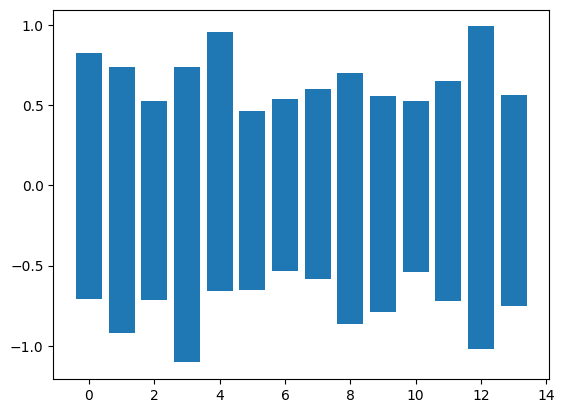

In [91]:
feature_df = pd.DataFrame(columns=['feature','layer','neuron','weight','abs_weight'])

for i,layer in enumerate(forecast.model.layers[:-1]): 
    w = layer.get_weights()
    w = np.array(w[0])
    n = 0
    for neuron in w.T:
        for f,name in zip(neuron,X.columns):
            feature_df.loc[len(feature_df)] = [name,i,n,f,abs(f)]
        
        n+=1
        
feature_df = feature_df.sort_values(by=['abs_weight'])
feature_df.reset_index(inplace=True)
feature_df = feature_df.drop(['index'], axis=1)

plt.bar(feature_df['feature'],feature_df['weight'])
plt.show()

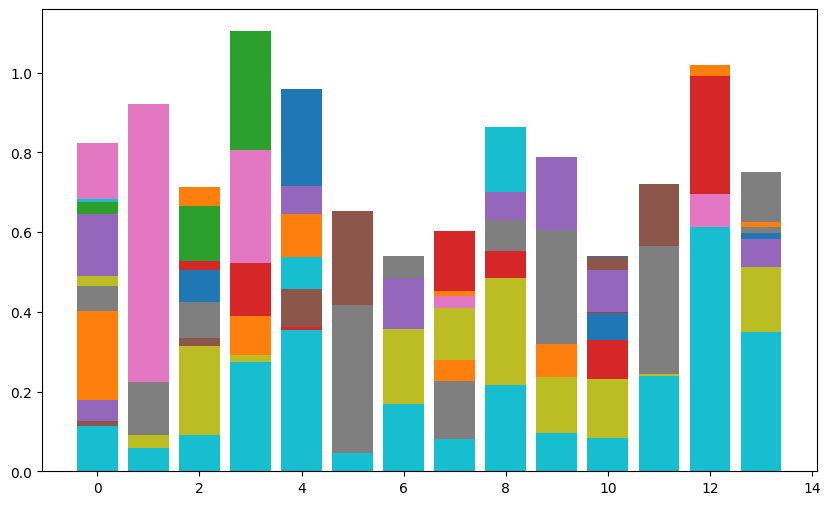

In [96]:
grouped_df = feature_df.groupby(['feature', 'neuron'])['abs_weight'].sum().reset_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
for neuron in grouped_df['neuron'].unique():
    feature_data = grouped_df[grouped_df['neuron'] == neuron]
    plt.bar(feature_data['feature'], feature_data['abs_weight'], label=feature)

In [52]:
feature_df_grouped

weight  abs_weight
feature neuron layer                      
0.0     0.0    0.0   -0.034123    0.034123
        1.0    0.0    0.042840    0.042840
        2.0    0.0    0.067985    0.067985
        3.0    0.0    0.027663    0.027663
        4.0    0.0    0.114916    0.114916
...                        ...         ...
13.0    395.0  0.0   -0.288851    0.288851
        396.0  0.0   -0.146225    0.146225
        397.0  0.0   -0.400016    0.400016
        398.0  0.0    0.512568    0.512568
        399.0  0.0   -0.349350    0.349350

[5600 rows x 2 columns]

In [68]:
one_week_prediction = []
days = 10
number_of_30_minutes = days * 24
end_train = datetime(2024, 1, 9, 0, 0, 0)

start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(days=30)



for i in range(0, number_of_30_minutes):
    if i % 20 == 0:
        print(f"Predicting {i} of {number_of_30_minutes}")
    next_steps = forecast.get_forecast_next_steps(
        left_time_interval=start_of_data_loader_for_forecast,
        right_time_interval=end_of_data_loader_for_forecast,
    )
    one_week_prediction.append(next_steps)
    start_of_data_loader_for_forecast += timedelta(hours=1)
    end_of_data_loader_for_forecast += timedelta(hours=1)




Predicting 0 of 240
SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2024-01-09T00:00:00Z' AND time <= '2024-02-08T00:00:00Z' GROUP BY time(1m) FILL(0)
SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2024-01-09T00:00:00Z' AND time <= '2024-02-08T00:00:00Z' AND ("entity_id"='esphome_web_c771e8_ntc_temperature_b_constant' OR "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2') GROUP BY time(1m) FILL(0)
SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-01-09T00:00:00Z' AND time <= '2024-02-08T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(1m) FILL(null)
SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-01-09T00:00:00Z' AND time <= '2024-02-08T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' G

In [69]:
print(one_week_prediction)

[[0.051557542592708804, 0.052805394142181925, 0.049338565604554706, 0.049195212657749204, 0.04954188882862164, 0.05085095812820856], [0.052805394142181925, 0.049338565604554706, 0.049195212657749204, 0.04954188882862164, 0.05085095812820856, 0.049747013957919764], [0.049338565604554706, 0.049195212657749204, 0.04954188882862164, 0.05085095812820856, 0.049747013957919764, 0.05400990096032473], [0.049195212657749204, 0.04954188882862164, 0.05085095812820856, 0.049747013957919764, 0.05400990096032473, 0.05062668775582912], [0.04954188882862164, 0.05085095812820856, 0.049747013957919764, 0.05400990096032473, 0.05062668775582912, 0.051750957813148785], [0.05085095812820856, 0.049747013957919764, 0.05400990096032473, 0.05062668775582912, 0.051750957813148785, 0.05071737457693531], [0.049747013957919764, 0.05400990096032473, 0.05062668775582912, 0.051750957813148785, 0.05071737457693531, 0.05152898685005474], [0.05400990096032473, 0.05062668775582912, 0.051750957813148785, 0.05071737457693531

In [82]:
concacted = pd.DataFrame(one_week_prediction)
print(concacted)
# transform to 6 columnsf df

shifted_df = concacted.copy()
for i in range(0, 6):
    shifted_df[i] = shifted_df[i].shift(i)

            0         1         2         3         4         5
0    0.051558  0.052805  0.049339  0.049195  0.049542  0.050851
1    0.052805  0.049339  0.049195  0.049542  0.050851  0.049747
2    0.049339  0.049195  0.049542  0.050851  0.049747  0.054010
3    0.049195  0.049542  0.050851  0.049747  0.054010  0.050627
4    0.049542  0.050851  0.049747  0.054010  0.050627  0.051751
..        ...       ...       ...       ...       ...       ...
235  0.049500  0.051583  0.047456  0.044710  0.169909  0.355924
236  0.051583  0.047456  0.044710  0.169909  0.355924  0.556442
237  0.047456  0.044710  0.169909  0.355924  0.556442  0.455723
238  0.044710  0.169909  0.355924  0.556442  0.455723  0.335429
239  0.169909  0.355924  0.556442  0.455723  0.335429  0.044463

[240 rows x 6 columns]


In [71]:
real_data_left_interval = start_of_data_loader_for_forecast  + timedelta(days=30)
real_data_right_interval = real_data_left_interval + timedelta(days=days)
real_data,_ = dataHandlerZuka.get_data_for_prediction(real_data_left_interval, real_data_right_interval)



SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2024-02-18T00:00:00Z' AND time <= '2024-02-28T00:00:00Z' GROUP BY time(1m) FILL(0)
SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2024-02-18T00:00:00Z' AND time <= '2024-02-28T00:00:00Z' AND ("entity_id"='esphome_web_c771e8_ntc_temperature_b_constant' OR "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2') GROUP BY time(1m) FILL(0)
SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-02-18T00:00:00Z' AND time <= '2024-02-28T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(1m) FILL(null)
SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-02-18T00:00:00Z' AND time <= '2024-02-28T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(1m) FIL

<AxesSubplot:>

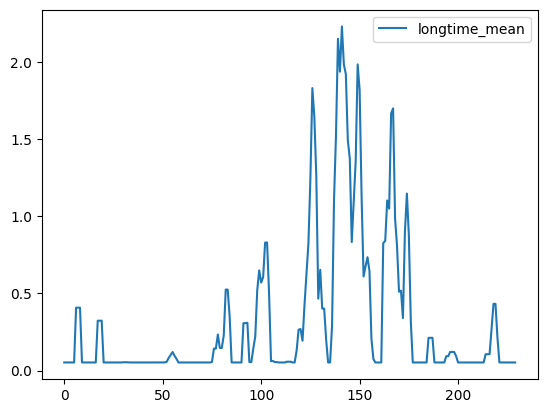

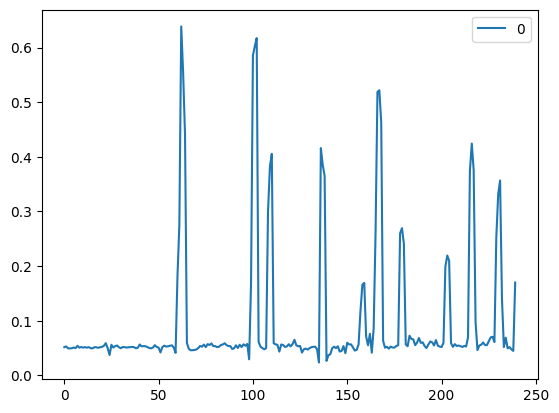

In [83]:
real_data.plot(y='longtime_mean')
shifted_df.plot(y=0)


In [84]:
shited_cropped = shifted_df.copy().loc[:real_data.shape[0]-1,:]
real_data = real_data.copy().loc[:shited_cropped.shape[0]-1,:]

shited_cropped['truth'] = real_data['longtime_mean'].values
shited_cropped.dropna(inplace=True)

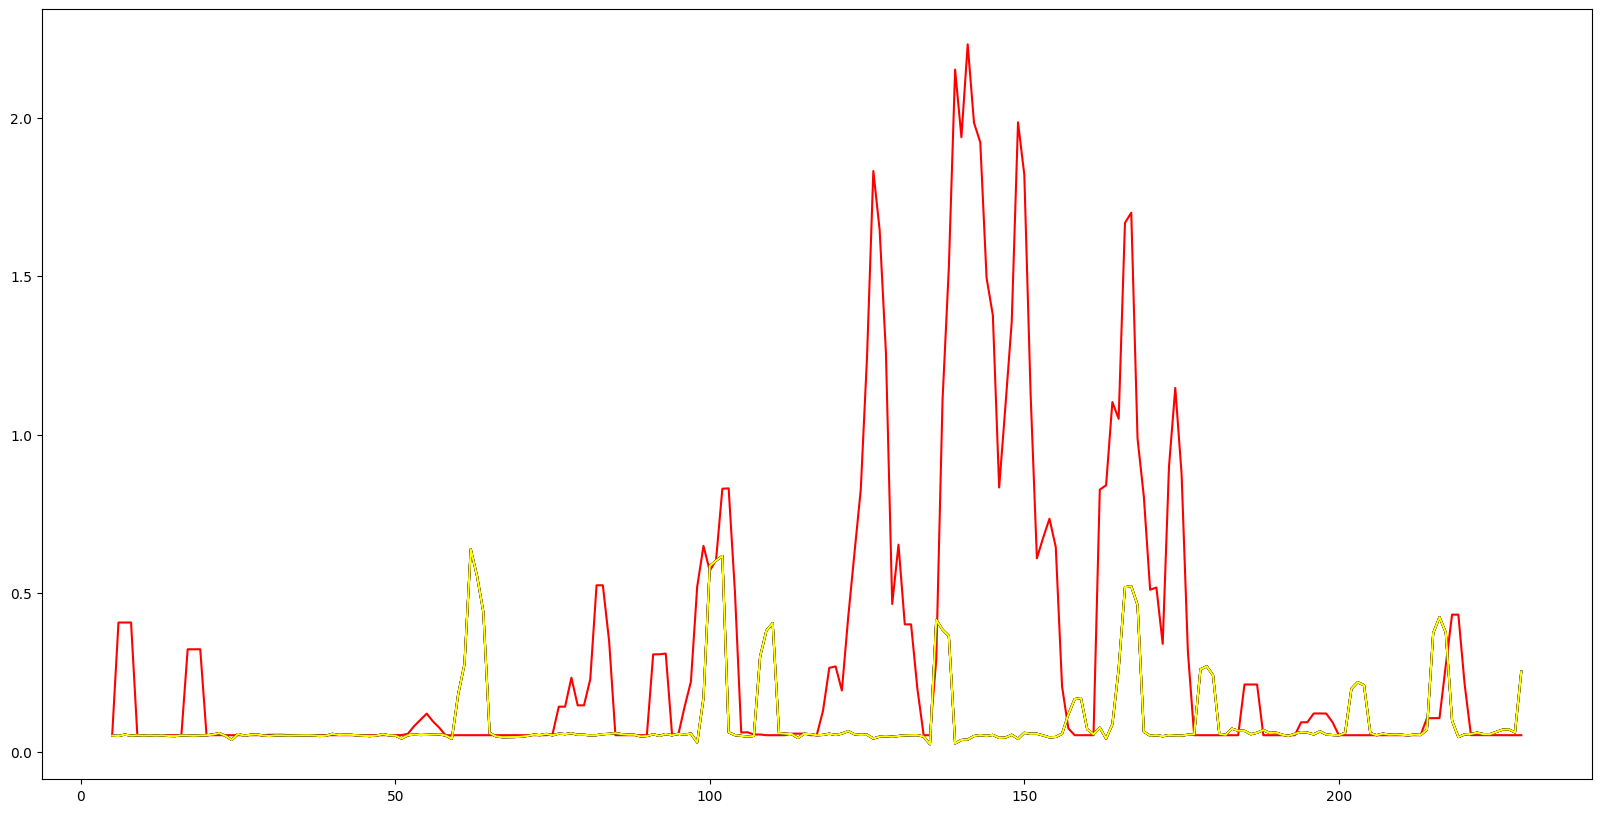

In [85]:
#plot shifted_cropped vs truth
# set plot wider
plt.figure(figsize=(20, 10))
plt.plot(shited_cropped['truth'][:], label='truth', color='red')
plt.plot(shited_cropped[0][:], label='predicted 0', color='green')
plt.plot(shited_cropped[1][:], label='predicted 1', color='blue')
plt.plot(shited_cropped[2][:], label='predicted 2', color='orange')
plt.plot(shited_cropped[3][:], label='predicted 3', color='purple')
plt.plot(shited_cropped[4][:], label='predicted 4', color='black')
plt.plot(shited_cropped[5][:], label='predicted 5', color='yellow')



In [75]:

left_test = datetime(2023,12,30)
right_test = datetime(2024,4,1)

from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

# df_test_direct, _ = forecast.dataHandler.get_data_for_prediction(left_test, right_test)
df_test_direct = df_test_zuka
df_test_norm = df_test_direct.reset_index(drop=True).copy()

# df_test_norm = df_test_zuka.copy()
df_test_norm[df_test_norm.columns] = forecast.scaler.transform(df_test_norm)


In [76]:
test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                     target_names = predicted_columns, 
                     lookback = forecast.lookback,
                     delay = forecast.delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test_norm.shape[0])
(X, y_truth) = next(test_gen)
# X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

y_pred = forecast.model.predict(X)

18/18 [==============================] - 0s 4ms/step


In [77]:
num_targets = len(predicted_columns)
len_columns = len(df_test_norm.columns)
num_features = len_columns - num_targets


# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)


y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)

y_truth_concat = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth_concat = forecast.scaler.inverse_transform(y_truth_concat)

# create a dataframe from y_pred_inv and y_truth_concat
y_pred_inv_df = pd.DataFrame(y_pred_inv, columns=df_test.columns)
y_truth_concat_df = pd.DataFrame(y_truth_concat, columns=df_test.columns)

y_pred_inv_df['truth'] = y_truth_concat_df['longtime_mean']
y_pred_inv_df['longtime_mean'] = y_pred_inv_df['longtime_mean'].clip(lower=0.05)

y_pred_inv_df = y_pred_inv_df.dropna()  

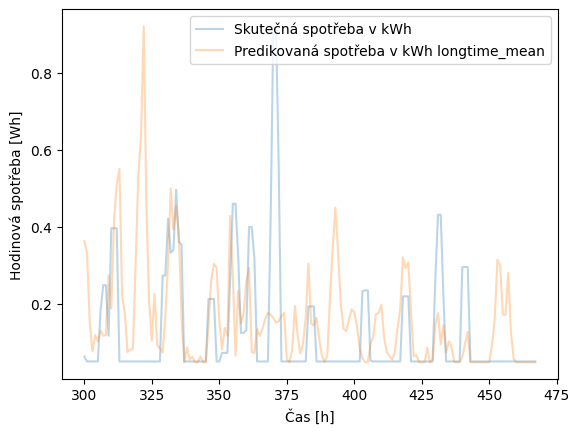

R2 =  0.024963465256540803
mse =  0.038464518547398026
rmse =  0.19612373274899197
integral delta =  -5.792397803562267
integral_truth =  79.87617269765654
integral_pred =  85.66857050121881
mape: 129.89938357646426


In [100]:





for i in range(num_targets):
    j = 300
    
    plt.figure()
    plt.plot(y_pred_inv_df['truth'][j:168+j], label=f'Skutečná spotřeba v kWh', alpha=0.3)
    plt.plot(y_pred_inv_df['longtime_mean'][j:168+j], label=f'Predikovaná spotřeba v kWh {predicted_columns[i]}', alpha=0.3)
    # set axis labels
    mape = np.mean(np.abs((y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']) / y_pred_inv_df['truth'])) * 100
    plt.xlabel('Čas [h]')
    plt.ylabel('Hodinová spotřeba [Wh]')
    plt.legend()
    plt.show()
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv_df['longtime_mean'],y=y_pred_inv_df['truth'])
    r2 = np.corrcoef(y_pred_inv_df['truth'], y_pred_inv_df['longtime_mean'])[0, 1] ** 2
    mse = mean_squared_error(y_true=y_pred_inv_df['truth'], y_pred=y_pred_inv_df['longtime_mean'], squared=True)
    rmse = mean_squared_error(y_true=y_pred_inv_df['truth'], y_pred=y_pred_inv_df['longtime_mean'], squared=False)


    print('R2 = ',r2)
    print('mse = ',mse)
    print('rmse = ',rmse)
    #print integral of y_pred_curr - y_truth_curr
    print('integral delta = ',np.trapz(y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']))
    print('integral_truth = ',np.trapz(y_pred_inv_df['truth']))
    print('integral_pred = ',np.trapz(y_pred_inv_df['longtime_mean']))
    print('mape:', mape)



In [79]:

from pytz import utc
import pandas as pd
import numpy as np
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_data = datetime(2023, 12, 10)
end_of_training_data = datetime(2023, 12, 31, 0, 0, 0)
dataHandler = DataHandler(
    "localhost",
    "smart_home_zukalovi",
    "root",
    "root",
    "shelly1pm_84cca8b07eae",
    "shelly1pm_84cca8b07eae_power",
    "esphome_web_c771e8_tmp3",
    "esphome_web_c771e8_ntc_temperature_b_constant",
    "esphome_web_c771e8_ntc_temperature_b_constant_2",
    device_tracker_entity_id="klara_z_iphone",
    home_longitude=49.412897925874184,
home_latitude=16.514843458109933,
start_of_data=start_of_data,
)



In [80]:
# df_train_norm to csv with header as colun name
df_train_norm.to_csv('df_train_norm.csv', header=True, index=False)

NameError: name 'df_train_norm' is not defined

In [ ]:
# def r2_keras(y_true, y_pred):
#     """Coefficient of Determination 
#     """
#     SS_res =  K.sum(K.square( y_true - y_pred ))
#     SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def r2_keras(y_true, y_pred):
    """Coefficient of Determination for multiple outputs"""
    SS_res = K.sum(K.square(y_true - y_pred), axis=0)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis=0)), axis=0)
    return K.mean(1 - SS_res / (SS_tot + K.epsilon()))

## Create LSTM model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU
- can also use lightwieght GRU layers

## Fit the Model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU

## Get model predictions on df_test
- get (X,y_truth) by calling train_gen using next
- set the batch_size

In [ ]:
model = load_model('lstm_model_mul_var.keras', custom_objects={'r2_keras': r2_keras})

In [ ]:
df_test_norm.shape

In [ ]:
# append a value to all rows in longtimemean column zeroes

test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                      target_names = predicted_columns, 
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test.shape[0])
(X, y_truth) = next(test_gen)
y_pred = model.predict(X)

num_targets = len(predicted_columns)
len_columns = len(df_test.columns)
num_features = len_columns - num_targets

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)
y_pred_inv = scaler.inverse_transform(y_pred_inv)

y_truth = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth = scaler.inverse_transform(y_truth)


In [ ]:
y_pred_abs = np.abs(y_pred_inv) - 0.2
for i in range(num_targets):
    plt.figure()
    plt.plot(y_truth[:, i], label=f'True {predicted_columns[i]}')
    plt.plot(y_pred_abs[:, i], label=f'Predicted {predicted_columns[i]}')
    plt.legend()
    plt.show()
    y_pred_curr = y_pred_abs[:48, i]
    y_truth_curr = y_truth[:48, i]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_curr,y=y_truth_curr)
    mse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=True)
    rmse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=False)


    print('R2 = ',r_value*r_value)
    print('mse = ',mse)
    print('rmse = ',rmse)
    #print integral of y_pred_curr - y_truth_curr
    print('integral = ',np.trapz(y_pred_curr - y_truth_curr))
    

In [ ]:
from datetime import timedelta, datetime
import pandas as pd


In [ ]:
def add_empty_row(df, date_time):
    new_row_df = pd.DataFrame(
        columns=df.columns,
        data=[
            [
                0,
                0,
                0,
                0,
                0,
                0,
                np.sin(2 * np.pi * date_time.weekday() / 7),
                np.cos(2 * np.pi * date_time.weekday() / 7),
                np.sin(2 * np.pi * date_time.hour / 24),
                np.cos(2 * np.pi * date_time.hour / 24),
                np.sin(2 * np.pi * date_time.minute / 60),
                np.cos(2 * np.pi * date_time.minute / 60),
            ]
        ],
    )
    df = pd.concat([df, new_row_df], ignore_index=True)
    df = df.reset_index(drop=True)
    
    return df

def get_forecast_next_steps(left_time_interval, right_time_interval):
    # Define the indices for the different predictions and truths

    num_targets = len(predicted_columns)
    len_columns = len(df_test.columns)


    forecast_future = pd.DataFrame()

    df_all = dataHandler.get_data_for_prediction(
        left_time_interval=left_time_interval,
        right_time_interval=right_time_interval,
        predicted_columns=predicted_columns,
    )
    df_all = df_all.dropna()
    df_all = df_all.reset_index(drop=True)
    forecast_future = pd.DataFrame()

    current_forecast_begin_date = right_time_interval + timedelta(hours=0.5)
    
    df_all = add_empty_row(df_all, current_forecast_begin_date)
    
    current_forecast_begin_date += timedelta(hours=0.5)

    # prediction for next 6 hours
    for i in range(0, 12):
        df_all = add_empty_row(df_all, current_forecast_begin_date)
        current_forecast_begin_date += timedelta(hours=0.5)

        df_predict_norm = df_all.copy()

        df_predict_norm[df_all.columns] = scaler.transform(df_all)
        # create predict df with values
        predict_gen = mul_generator(
            dataframe=df_predict_norm,
            target_names=predicted_columns,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=1,
            shuffle=False,
            batch_size=df_predict_norm.shape[0],
        )

        (X, y_truth) = next(predict_gen)

        y_pred = model.predict(X, verbose=0)
        # np.expand_dims(y_truth,axis=1).shape
        y_pred_inv = np.concatenate(
            (y_pred, np.zeros((y_pred.shape[0], len_columns-num_targets))), axis=1
        )
        y_pred_inv = scaler.inverse_transform(y_pred_inv)
        # get last predicted value
        y_pred_inv = y_pred_inv[-1, :]

        # append y_pred_inv to df_all
        df_all.iloc[-2,:num_targets] = y_pred_inv[:num_targets]
        # drop first row
        df_all = df_all[1:]

        forecast_future = pd.concat(
            [
                forecast_future,
                df_all.iloc[-2][:num_targets],
            ],
            axis=0,
        )
        forecast_future = forecast_future.reset_index(drop=True)
        

    return forecast_future, df_all

# last 48 values

In [ ]:

one_week_prediction = []
number_of_30_minutes = 14*24*2
end_train = datetime(2023,12,29, 0, 0, 0)
start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(hours=48)


for i in range(0, number_of_30_minutes):
    next_steps, _ = get_forecast_next_steps(left_time_interval=start_of_data_loader_for_forecast, right_time_interval=end_of_data_loader_for_forecast)
    one_week_prediction.append(next_steps)
    start_of_data_loader_for_forecast += timedelta(minutes=30)
    end_of_data_loader_for_forecast += timedelta(minutes=30)

In [ ]:
df_truth = dataHandler.get_data_for_prediction(left_time_interval=end_train+timedelta(hours=48), right_time_interval=end_train+timedelta(hours=48)+timedelta(minutes=30*number_of_30_minutes))

In [ ]:
list_df = []
for df in one_week_prediction:
    df_reshaped = (pd.DataFrame(np.reshape(df.values, (-1, 6)))).T
    df_reshaped['prediction'] = [i for i in predicted_columns]

    # transpose 
    list_df.append(df_reshaped)
merged_df = pd.concat(list_df, ignore_index=True)
merged_df['DataFrame_Order'] = [i for i in range(len(list_df)) for _ in range(6)]

    


In [ ]:
longtime_mean = merged_df[merged_df['prediction'] == 'longtime_mean']
distance_from_home = merged_df[merged_df['prediction'] == 'distance_from_home']
speed_towards_home = merged_df[merged_df['prediction'] == 'speed_towards_home']
count = merged_df[merged_df['prediction'] == 'count']
heading_to_home_sin = merged_df[merged_df['prediction'] == 'heading_to_home_sin']
heading_to_home_cos = merged_df[merged_df['prediction'] == 'heading_to_home_cos']




In [ ]:
merged_df

In [ ]:
# shift the columns by -i
shifted_df = merged_df.copy()
for j in predicted_columns:
    for i in range(0,12):
        shifted_df.loc[shifted_df['prediction'] == j, i] = shifted_df.loc[shifted_df['prediction'] == j, i].shift(-i)
        


In [ ]:
#keep only columns from predicted columns
data_truth = df_truth[predicted_columns]

In [ ]:
result_df = shifted_df.copy()
result_df['truth'] = 0  
for prediction_column in predicted_columns:

    for i in range(0,672):
        result_df.loc[(result_df['prediction'] == prediction_column) & (result_df['DataFrame_Order'] == i), 'truth' ] = data_truth.loc[i, prediction_column]

In [ ]:
result_df = result_df.dropna()

In [ ]:
for predicted_column in predicted_columns:
    number_of_steps = 1
    #create a list of collors from 0 to 12 based on color
    colors = plt.cm.viridis(np.linspace(0, 1, number_of_steps))
    for i in range(0, number_of_steps):
        plt.plot(result_df.loc[result_df['prediction']==predicted_column,i][:], label=f'predicted_{predicted_column}_{i}', color=colors[i], alpha=0.2)
    # i =0
    # plt.plot(df_shift[i], label=f'{i}_step_ahead')
    plt.plot(result_df.loc[result_df['prediction'] == predicted_column,'truth'][:], label='truth')
    plt.legend()   
    plt.show()

### Need to remove normalization
- since we preformed normlization transform on 7 cols of dataframe, we need to add dummy colums to preds

### Get R2 for this prediction

In [ ]:
print(y_truth.shape)

In [ ]:
print(y_pred.shape)

In [ ]:
#plot y_truth and y_pred
plt.plot(y_truth[0], color = 'red', label = 'Real data')

plt.plot(y_pred)


In [ ]:

plt.plot(y_truth, color = 'red', linestyle='dotted')
plt.plot(y_pred, color = 'blue', linestyle='dotted')
# change x ticks to dates
print(np.arange(0, df_test.shape[0], step=24))
# create list of dates by 1 hour from 2023-11-01 00:00:00 to 2023-11-30 23:00:00
start = pd.to_datetime('2023-12-16 19:00:00')
end = start + pd.Timedelta(hours=df_test.shape[0])
dates = pd.date_range(start, end, freq='1H')

# transform dates to format MM-DD HH
dates = dates.strftime('%Y-%m-%d')
# set xticks to dates
plt.xticks(np.arange(0, df_test.shape[0], step=24), dates[np.arange(0, df_test.shape[0], step=24)], rotation=45)

#add legend
plt.legend(['skutečnost','predikce'])

# add x and y label
plt.xlabel('Datum')
plt.ylabel('Spotřeba tepla [kJ]')


plt.show()

## Let's try the evaluate_generator in keras

In [ ]:
(_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)
print('R2 = ',r2)
